## Introduction
This tutorial explores the implementation of the Quantum Approximate Optimization Algorithm (QAOA) using Qiskit. QAOA is a hybrid algorithm that combines quantum and classical computing to solve complex optimization problems. The tutorial focuses on solving the Maximum-Cut (Max-Cut) problem for a small graph and then demonstrates how to scale it for more practical applications. All quantum hardware executions in this tutorial are designed to fit within the time constraints of the freely available Open Plan.

The Max-Cut problem is a well-known NP-hard optimization challenge with applications in clustering, network analysis, and statistical physics. It involves dividing the nodes of a graph into two sets in such a way that the number of edges connecting the two sets is maximized. In other words, the objective is to create a partition that results in the highest possible number of edges crossing between the two groups.

###  QAOA for a Simple Graph
To explore how quantum computing can assist in solving optimization problems, we first apply the Quantum Approximate Optimization Algorithm (QAOA) to a small instance of the Maximum-Cut (Max-Cut) problem.

Before translating this into a quantum framework, it is useful to recognize that Max-Cut is essentially a classical optimization problem. It can be formulated as minimizing a function \( h(z) \):

$$
\min_{z \in \{0,1\}^m} h(z),
$$

where \( z \) represents a vector whose entries correspond to individual graph nodes. Each entry is constrained to be either \( 0 \) or \( 1 \), signifying membership in one of the two partitions. In this example, we consider a graph with \( m = 5 \) nodes.

To determine if an edge \( (u,v) \) is part of the cut, we use a function that evaluates whether exactly one of the nodes belongs to the selected subset:

$$
z_u + z_v - 2 z_u z_v.
$$

This expression equals 1 only when either $z_{u}$ or $z_{v}$ is 1, meaning the edge contributes to the cut. Otherwise, it evaluates to 0. The objective is to maximize the number of such edges:

$$
\max_{z \in \{0,1\}^m} \sum_{(u,v)} z_{u} + z_{v} - 2 z_u z_v.
$$

Rewriting this as a minimization problem:

$$
\min_{z \in \{0,1\}^m} \sum_{(u,v)} 2 z_u z_v - z_u - z_v.
$$

Here, the function \( h(z) \) attains its minimum when the number of edges in the cut is maximized. At this stage, no quantum concepts have been introduced yet. The next step is to transform the problem into a quantum-compatible form.

Now, we initialize a graph containing \( m = 5 \) nodes.

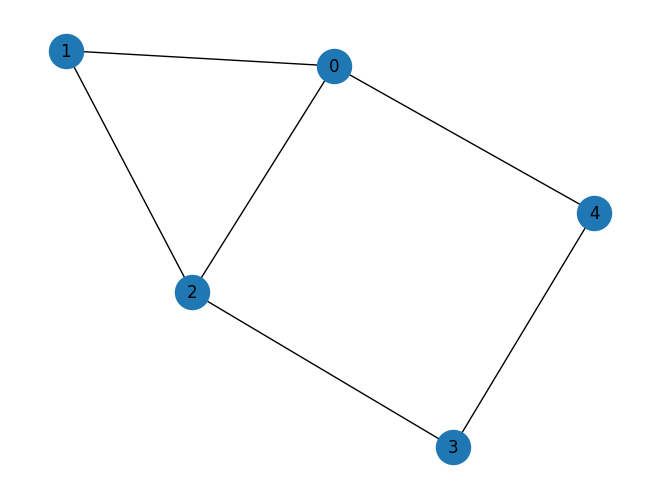

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

#### Mapping Problem into Quantum Framework
The initial step in this approach involves encoding the classical optimization problem into quantum circuits and operators. This transformation consists of three key stages:

- Reformulating the problem mathematically to fit within the Quadratic Unconstrained Binary Optimization (QUBO) framework.
- Expressing the optimization problem as a Hamiltonian, where the lowest-energy state (ground state) corresponds to the optimal solution.
- Constructing a quantum circuit capable of preparing this ground state, leveraging a technique similar to quantum annealing.

**Note:** In the QAOA framework, the objective is to define an operator (Hamiltonian) that encodes the cost function of the hybrid algorithm. Additionally, a parametrized quantum circuit (Ansatz) is used to generate quantum states representing possible solutions. These quantum states are sampled and evaluated against the cost function.

##### Graphical Representation to Optimization Model

The first step in the mapping process is a change in notation. The optimization problem can be formulated using the QUBO framework as follows:

$$
\underset{y \in \{0,1\}^m}{\operatorname{min}} \ y^T R y,
$$
You can then reformulate the QUBO problem as a Hamiltonian (which, in this case, is a matrix representing the system's energy):

$$
H_C = \sum_{i,j} Q_{ij} Z_i Z_j + \sum_i b_i Z_i.
$$


##### Reformulation Steps from the QAOA Problem to the Hamiltonian  

To rewrite the QAOA problem in this way, first replace the binary variables $x_i$ with a new set of variables $z_i \in \{-1,1\}$ using the transformation  

$$
x_i = \frac{1 - z_i}{2}.
$$  

Here, if $x_i = 0$, then $z_i = 1$, and vice versa. Substituting $x_i$ in the optimization problem $x^T Q x$, we obtain:  

$$
x^T Q x = \sum_{i,j} Q_{ij} x_i x_j = \frac{1}{4} \sum_{i,j} Q_{ij} (1 - z_i)(1 - z_j).
$$  

Expanding the expression gives:  

$$
\frac{1}{4} \sum_{i,j} Q_{ij} z_i z_j - \frac{1}{4} \sum_{i,j} (Q_{ij} + Q_{ji}) z_i + \frac{n^2}{4}.
$$  

Now, define  

$$
b_i = -\sum_j (Q_{ij} + Q_{ji}),
$$  

and removing the constant offset $n^2$ and factor $\frac{1}{4}$, we get an equivalent formulation:  

$$
\min_{x \in \{0,1\}^n} x^T Q x \quad \Longleftrightarrow \quad \min_{z \in \{-1,1\}^n} z^T Q z + b^T z.
$$  

Since $b$ depends on $Q$, the transformation preserves the optimization problem's structure.  

To obtain a quantum formulation, promote $z_i$ to a Pauli-$Z$ matrix:  

$$
Z_i =
\begin{bmatrix}
1 & 0 \\  
0 & -1  
\end{bmatrix}.
$$  

Substituting these matrices into the optimization problem results in the Hamiltonian:  

$$
H_C = \sum_{i,j} Q_{ij} Z_i Z_j + \sum_i b_i Z_i.
$$  

Since $Z$ matrices are embedded in the quantum computational space (Hilbert space of dimension $2^n \times 2^n$), terms like $Z_i Z_j$ are understood as tensor products $Z_i \otimes Z_j$. For instance, in a five-variable problem, the term $Z_1 Z_3$ is represented as:  

$$
I \otimes Z_3 \otimes I \otimes Z_1 \otimes I,
$$  

where $I$ is the $2 \times 2$ identity matrix.


##### Reformulation Steps from the QAOA Problem to the Hamiltonian  

To rewrite the QAOA problem in this way, first replace the binary variables $x_i$ with a new set of variables $z_i \in \{-1,1\}$ using the transformation:  

$$
x_i = \frac{1 - z_i}{2}.
$$  

Here, if $x_i = 0$, then $z_i = 1$, and vice versa. Substituting $x_i$ in the optimization problem $x^T Q x$, we obtain:  

$$
x^T Q x = \sum_{i,j} Q_{ij} x_i x_j = \frac{1}{4} \sum_{i,j} Q_{ij} (1 - z_i)(1 - z_j).
$$  

Expanding the expression gives:  

$$
\frac{1}{4} \sum_{i,j} Q_{ij} z_i z_j - \frac{1}{4} \sum_{i,j} (Q_{ij} + Q_{ji}) z_i + \frac{n^2}{4}.
$$  

Now, define  

$$
b_i = -\sum_j (Q_{ij} + Q_{ji}),
$$  

and removing the constant offset $n^2$ and factor $\frac{1}{4}$, we get an equivalent formulation:  

$$
\min_{x \in \{0,1\}^n} x^T Q x \quad \Longleftrightarrow \quad \min_{z \in \{-1,1\}^n} z^T Q z + b^T z.
$$  

Since $b$ depends on $Q$, the transformation preserves the optimization problem's structure.  

To obtain a quantum formulation, promote $z_i$ to a Pauli-$Z$ matrix:  

$$
Z_i =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}.
$$  

Substituting these matrices into the optimization problem results in the Hamiltonian:  

$$
H_C = \sum_{i,j} Q_{ij} Z_i Z_j + \sum_i b_i Z_i.
$$  

Since $Z$ matrices are embedded in the quantum computational space (Hilbert space of dimension $2^n \times 2^n$), terms like $Z_i Z_j$ are understood as tensor products $Z_i \otimes Z_j$. For instance, in a five-variable problem, the term $Z_1 Z_3$ is represented as:  

$$
I \otimes Z_3 \otimes I \otimes Z_1 \otimes I,
$$  

where $I$ is the $2 \times 2$ identity matrix.
This Hamiltonian is called the **cost function Hamiltonian**. It has the property that its ground state corresponds to the solution that minimizes the cost function $f(x)$.  

Therefore, to solve our optimization problem, we now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with high probability, yield the solution to:  

$$
\min f(x)
$$

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


##### Hamiltonian → Quantum Circuit  

The Hamiltonian $H_C$ contains the quantum definition of our problem. Now we can create a quantum circuit that will help sample good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.  

The general idea is to start in the ground state of a known system,  

$$
H^{\otimes n} |0 \rangle
$$  

and then steer the system into the ground state of the cost operator that we are interested in. This is done by applying the operators  

$$
\exp{(-i\gamma_k H_C)}
$$  

and  

$$
\exp{(-i\beta_k H_m)}
$$  

with angles $\gamma_1, \dots, \gamma_p$ and $\beta_1, \dots, \beta_p$.  

The quantum circuit that we generate is parametrized by $\gamma_i$ and $\beta_i$, so we can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state. In this case, we will try an example with one QAOA layer that contains two parameters:  
$$
\gamma_1,\beta_1
$$


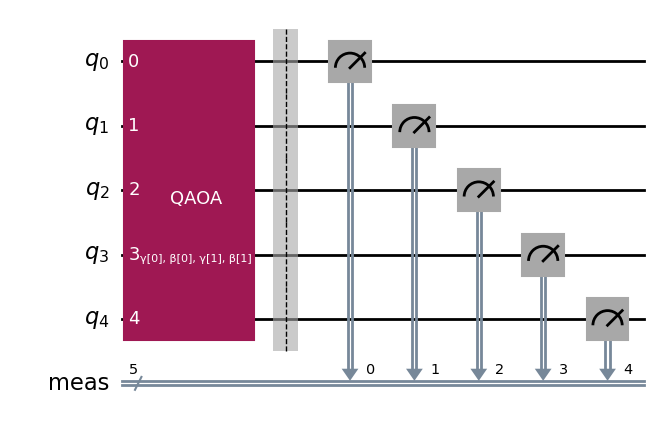

In [3]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [4]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

#### Step 2: Optimize Circuits for Quantum Hardware Execution  

The circuit above contains a series of abstractions useful for understanding quantum algorithms, but it is not directly executable on hardware. To run it on a QPU, the circuit must undergo a series of transformations, known as **transpilation** or **circuit optimization**.  

The Qiskit library provides a variety of **transpilation passes** designed for different circuit transformations. It is crucial to optimize the circuit for specific hardware constraints.  

##### Transpilation Steps  

Transpilation may involve several steps, such as:  

1. **Initial qubit mapping**: Assigning logical qubits (e.g., decision variables) to physical qubits on the device.  
2. **Unrolling**: Decomposing the circuit’s instructions into hardware-native gate operations.  
3. **Qubit routing**: Ensuring that interacting qubits are placed on physically adjacent qubits in the device.  
4. **Error suppression**: Applying single-qubit gates to mitigate noise via **dynamical decoupling**.  

More details on transpilation are available in the Qiskit documentation.  

The following code transforms and optimizes the abstract circuit into a format suitable for execution on quantum hardware through the **Qiskit IBM Runtime service**.


<IBMBackend('ibm_sherbrooke')>


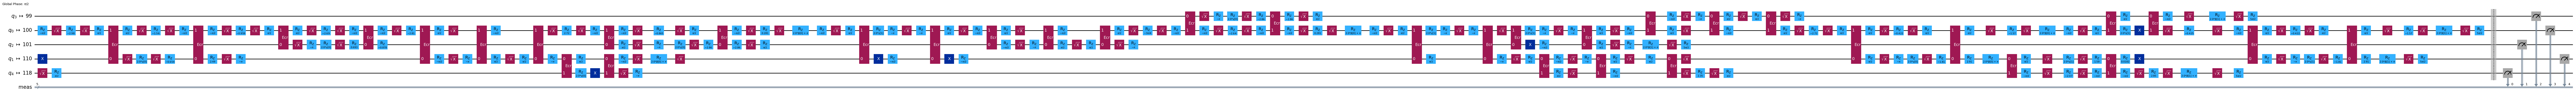

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

ibm_token = "dbee6b37586f6300e30a83f5787f6c951e109701040a52e75d5f6425add30891d91853a512abe601ca2abf25b710c27458f0784c399a79582cbda74b58e051c3"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

### Execute Using Qiskit Primitives  

In the **QAOA workflow**, the optimal QAOA parameters are found through an **iterative optimization loop**. This loop repeatedly evaluates quantum circuits and employs a **classical optimizer** to determine the optimal parameters \( \beta_k \) and \( \gamma_k \).  

#### Execution Loop  

The execution process consists of the following steps:  

1. **Define the initial parameters**: Start with arbitrary values for \( \beta_k \) and \( \gamma_k \).  
2. **Instantiate a session**: Create a **new session** that contains the optimization loop and the Qiskit **primitive** responsible for circuit sampling.  
3. **Find the optimal parameters**: Run the optimization loop to refine \( \beta_k \) and \( \gamma_k \).  
4. **Final execution**: Once the best parameters are found, execute the optimized circuit one last time to obtain a **final probability distribution**, which will be used in the post-processing step.  

##### Define Circuit with Initial Parameters  

We begin with an arbitrarily chosen set of initial parameters.


In [6]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

#### Using Qiskit Runtime Primitives  

To interact with **IBM® quantum backends**, we use the **Qiskit Runtime primitives**. There are two primary primitives available:  

- **Sampler**: Used when sampling measurement outcomes from a quantum circuit.  
- **Estimator**: Used when computing the **expectation value** of an operator.  

Since the goal is to **minimize the cost Hamiltonian** \( H_C \), we use the **Estimator primitive**. This is because the measurement of the cost function is simply the expectation value:  

$$ \langle H_C \rangle. $$  

In [7]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [ ]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

##### Sampling the Final Distribution  

Once the **optimal parameters** for the circuit are found, you can assign these parameters and **sample the final distribution** obtained with the optimized values.  

At this stage, the **Sampler primitive** is used, since it provides the **probability distribution of bitstring measurements** corresponding to the **optimal cut of the graph**.  

#### **Measurement Process**  

This step involves preparing a **quantum state** \( \psi \) on the quantum computer and then measuring it. A measurement collapses the state into a **single computational basis state**.  

For example, after measurement, we might obtain:  

$$ 010101110000... $$  

which corresponds to a **candidate solution** \( x \) for our initial optimization problem:  

- **Maximization task**:  
  $$ \max f(x) $$
- **Minimization task**:  
  $$ \min f(x) $$  

depending on the nature of the problem.  

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

### **Post-Processing: Returning the Result in Classical Format**  

The **post-processing step** interprets the **sampling output** to return a **solution** for the original optimization problem.  

In this case, we are interested in the **bitstring with the highest probability**, as it determines the **optimal cut** of the graph.  

#### **Interpreting the Result**  
- Due to **symmetries** in the problem, there are **four possible solutions**.  
- The **sampling process** will return one of these solutions, but **one bitstring** is likely to have a **slightly higher probability** than the others.  
- When we **plot the probability distribution**, we observe that **four specific bitstrings** stand out **significantly** compared to the rest.  

Thus, the **solution bitstring** can be selected based on its **highest occurrence** in the sampled distribution.  


In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

##### Vissualize the Best Cut

In [ ]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

and its calue will be : 

In [ ]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

### How it will look like at Large-Scale ?